In [40]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tensorflow.keras.utils import plot_model,pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from tensorflow.keras.preprocessing.text import Tokenizer
import bokeh.plotting as bp
from bokeh.models import HoverTool,LabelSet,ColumnDataSource
from sklearn.decomposition import PCA
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

In [5]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  3364k      0  0:00:24  0:00:24 --:--:-- 5263k


In [6]:
!tar -xf aclImdb_v1.tar.gz

In [7]:
print(os.listdir('aclImdb'))
print(os.listdir('aclImdb/train'))
print(os.listdir('aclImdb/test'))
print(sorted(glob('aclImdb/train/pos/*txt'))[:5])

['imdbEr.txt', 'test', 'imdb.vocab', 'README', 'train']
['urls_unsup.txt', 'neg', 'urls_pos.txt', 'unsup', 'urls_neg.txt', 'pos', 'unsupBow.feat', 'labeledBow.feat']
['neg', 'urls_pos.txt', 'urls_neg.txt', 'pos', 'labeledBow.feat']
['aclImdb/train/pos/0_9.txt', 'aclImdb/train/pos/10000_8.txt', 'aclImdb/train/pos/10001_10.txt', 'aclImdb/train/pos/10002_7.txt', 'aclImdb/train/pos/10003_8.txt']


In [8]:
def lee_review(ruta):
    with open(ruta,'r') as f:
        texto = f.read()
        return texto

In [9]:
train_pos = [lee_review(p) for p in sorted(glob('aclImdb/train/pos/*txt'))]
train_neg = [lee_review(p) for p in sorted(glob('aclImdb/train/neg/*txt'))]
test_pos = [lee_review(p) for p in sorted(glob('aclImdb/test/pos/*txt'))]
test_neg = [lee_review(p) for p in sorted(glob('aclImdb/test/neg/*txt'))]

print(len(train_pos),len(train_neg),len(test_pos),len(test_neg))

12500 12500 12500 12500


In [10]:
train = train_pos + train_neg
y_train = np.array([1]*len(train_pos) + [0]*len(train_neg))

test = test_pos + test_neg
y_test = np.array([1]*len(test_pos) + [0]*len(test_neg))

In [11]:
print(train[2137])

GREAT movie and the family will love it!! If kids are bored one day just pop the tape in and you'll be so glad you did!!!<br /><br />~~~Rube<br /><br />i luv raven-s!


In [12]:
def normaliza(x):
    return x.lower().replace('<br />',' ')

In [13]:
train = [normaliza(x) for x in train]
test = [normaliza(x) for x in test]
print(train[2137])

great movie and the family will love it!! if kids are bored one day just pop the tape in and you'll be so glad you did!!!  ~~~rube  i luv raven-s!


In [14]:
top_words = 5000

tk = Tokenizer(oov_token="(oov)",num_words=top_words)
tk.fit_on_texts(train)

In [15]:
X_train = tk.texts_to_sequences(train)
X_test = tk.texts_to_sequences(test)

In [16]:
print(train[2137])
print(X_train[2137])

great movie and the family will love it!! if kids are bored one day just pop the tape in and you'll be so glad you did!!!  ~~~rube  i luv raven-s!
[84, 17, 3, 2, 220, 77, 116, 9, 45, 359, 23, 1095, 28, 248, 40, 1715, 2, 2211, 8, 3, 487, 27, 35, 1260, 22, 119, 1, 10, 1, 1, 587]


In [18]:
print(tk.sequences_to_texts(X_train[2186:2787]))

["i loved this show growing up and i still watch the first season dvd at age (oov) today what can i say i grew up in a house much like the one on full house i had a dad two sisters and a dog i guess the only difference was that i did not live with my uncle and my (oov) best friend also i grew up with my mom in the house i don't know what i would have done without full house on television i think that (oov) played by (oov) (oov) d j played by kirk (oov) sister (oov) and michelle played by mary kate and ashley (oov) are my favorite characters i can relate to each of them because i am the middle child of my family like (oov) i am a younger sister like michelle and i am an older sister like d j i really like how the show always has moral values because i don't really like any of the o c like shows today i like the comedy of full house too uncle jesse john (oov) joey dave (oov) and danny bob (oov) are hilarious as the (oov) uncle (oov) friend and dad (oov) the story goes that after the (oov

In [19]:
longs = [len(x) for x in X_train]

([<matplotlib.axis.YTick at 0x315245d00>,
 [Text(0, 1000, '1000'),
  Text(0, 3000, '3000'),
  Text(0, 5000, '5000'),
  Text(0, 7000, '7000')])

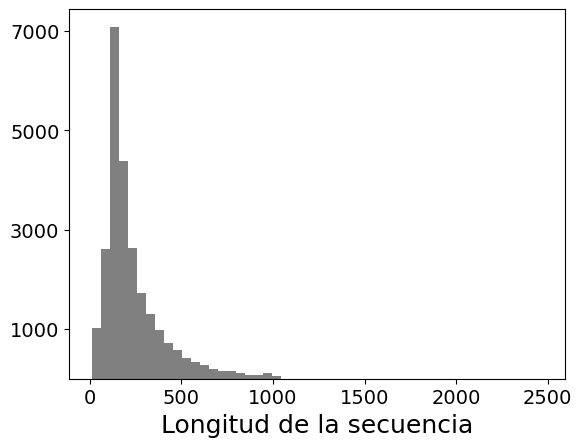

In [20]:
plt.hist(longs,bins=50,color='gray')
plt.xlabel('Longitud de la secuencia',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(range(1000,8000,2000),fontsize=14)


In [22]:
print(np.median(longs))

174.0


In [23]:
max_review_length = 250
X_train_pad = pad_sequences(X_train,maxlen=max_review_length)
X_test_pad = pad_sequences(X_test,maxlen=max_review_length)
print(X_train_pad.shape)

(25000, 250)


In [25]:
model = keras.Sequential([
    layers.Embedding(input_dim=top_words,output_dim=2,input_length=max_review_length,embeddings_regularizer=l2(0.01)),
    layers.Dropout(rate=0.5),
    layers.LSTM(units=5),
    layers.Dense(units=1,activation='sigmoid')
])

/Users/marcofura/anaconda3/envs/fundamentos_matematicos/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [27]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:
aux = train_test_split(X_train_pad,y_train,test_size=0.3,random_state=1,stratify=y_train)
X_tr_pad,X_val_pad,y_tr,y_val = aux
print(X_tr_pad.shape,X_val_pad.shape)
print(y_tr.shape,y_val.shape)

(17500, 250) (7500, 250)
(17500,) (7500,)


In [30]:
lista_callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss',patience=5),
    keras.callbacks.ModelCheckpoint('best_model.keras',monitor='val_loss',save_best_only=True)
]

In [31]:
historia = model.fit(X_tr_pad,y_tr,validation_data=(X_val_pad,y_val),epochs=40,batch_size=512,callbacks=lista_callbacks)

Epoch 1/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.5035 - loss: 0.7460 - val_accuracy: 0.5512 - val_loss: 0.6979
Epoch 2/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.5268 - loss: 0.6955 - val_accuracy: 0.5124 - val_loss: 0.6931
Epoch 3/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.5372 - loss: 0.6930 - val_accuracy: 0.5523 - val_loss: 0.6927
Epoch 4/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.5718 - loss: 0.6921 - val_accuracy: 0.5901 - val_loss: 0.6849
Epoch 5/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.6308 - loss: 0.6726 - val_accuracy: 0.7119 - val_loss: 0.6362
Epoch 6/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.7204 - loss: 0.6243 - val_accuracy: 0.7767 - val_loss: 0.5822
Epoch 7/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.7696 - loss: 0.5771 - val_accuracy: 0.8137 - val_loss: 0.5235
Epoch 8/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.7891 - loss: 0.5421 - val_accuracy: 0.8209 - v

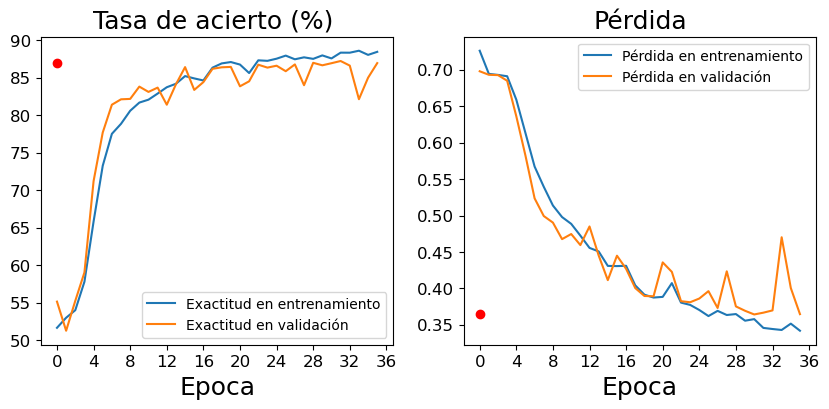

In [32]:
f = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
h = historia.history
e = np.argmin(h['val_loss'])
plt.plot(100*np.array(h['accuracy']),label='Exactitud en entrenamiento')
plt.plot(100*np.array(h['val_accuracy']),label='Exactitud en validación')
plt.plot(100*h['val_accuracy'][e],'or')
plt.title('Tasa de acierto (%) ',fontsize=18)
plt.xlabel('Epoca',fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
f.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.subplot(1,2,2)
plt.plot(h['loss'],label='Pérdida en entrenamiento')
plt.plot(h['val_loss'],label='Pérdida en validación')
plt.plot(h['val_loss'][e],'or')
plt.title('Pérdida',fontsize=18)
plt.xlabel('Epoca',fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
f.gca().xaxis.set_major_locator(MaxNLocator(integer=True))



In [33]:
model = keras.models.load_model('best_model.keras')
scores_tr = model.evaluate(X_tr_pad,y_tr,return_dict=True)
scores_val = model.evaluate(X_val_pad,y_val,return_dict=True)
scores_test = model.evaluate(X_test_pad,y_test,return_dict=True)
print(100*scores_tr['accuracy'],100*scores_val['accuracy'],100*scores_test['accuracy'])

547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9290 - loss: 0.2802
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8724 - loss: 0.3598
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8629 - loss: 0.3706
92.8514301776886 86.90666556358337 86.45600080490112


In [34]:
pca = PCA(n_components=2)
embeddings = model.layers[0].embeddings.numpy()
words_pca = pca.fit_transform(embeddings)


In [36]:
bp.output_notebook()
p = bp.figure(width=700,height=600,title='Nube de palabras',x_axis_label='PCA 1',y_axis_label='PCA 2')
p.title.text_font_size = '16pt'
p.xaxis.axis_label_text_font_style = 'normal'
p.yaxis.axis_label_text_font_size = '16pt'
p.xaxis.axis_label_text_font_size = '16pt'
p.yaxis.axis_label_text_font_style = 'normal'
n_words = embeddings.shape[0]

Loading BokehJS ...

In [41]:
aux = ColumnDataSource({
    "componente_1":words_pca[:,0],
    "componente_2":words_pca[:,1],
    "words":["(padding)"]+[tk.index_word[i] for i in range(1,n_words)]})


In [43]:
p.scatter(x='componente_1',y='componente_2',source=aux,color="black")
labels_p = LabelSet(x='componente_1',y='componente_2',text='words',source=aux,level='glyph',x_offset=5,y_offset=5,text_font_size='10pt',text_color='black')
p.add_layout(labels_p)
hover = p.select(dict(type=HoverTool))
hover.tooltips = {"word":"@words"}
bp.show(p)

In [44]:
def most_similar_words(word,n=5):
    n_latent_dimensions = embeddings.shape[1]
    ind = tk.word_index[word]
    aux = np.reshape(embeddings[ind,:],(1,n_latent_dimensions))
    dists = pairwise_distances(aux,embeddings).flatten()
    inds = dists.argsort().tolist()
    inds.remove(ind)
    return [tk.index_word[i] for i in inds[:n]]

In [45]:
print(most_similar_words('boring'))
print(most_similar_words('perfect'))

['mediocre', 'badly', 'mst3k', 'education', 'wasted']
['enjoyable', 'gem', '7', 'wonderfully', 'favorite']
